In [ ]:
!pip install econml xgboost scikit-learn matplotlib seaborn -q

In [ ]:
# CELL 1: IMPORT THƯ VIỆN & CHUẨN BỊ DỮ LIỆU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML, CausalForestDML
from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings('ignore')

# 1. Đọc dữ liệu
df = pd.read_csv('Data_Panel_DML_Ready.csv')

# Drop các dòng có NaN ở các biến quan trọng (để tránh lỗi XGBoost)
features = ['Sigma', 'Ret', 'Dturn', 'Size', 'Lev', 'ROA', 'Growth', 'Big4', 'Board']
df = df.dropna(subset=['NCSKEW', 'DUVOL', 'D'] + features)

# 2. Định nghĩa các tập biến
X = df[features] # Biến kiểm soát (High-dimensional Controls)
W = df[['RISK_LV', 'State_Owner']] # Biến điều tiết (Moderators cho Heterogeneity)

# Để XGBoost trong DML học tốt hơn, ta gộp W vào X khi chạy mô hình cơ sở
X_all = pd.concat([X, W], axis=1)

T = df['D'] # Biến Treatment (DiD)
groups = df['Ticker'] # Biến nhóm để tính Clustered Standard Errors (Rất quan trọng cho Panel Data)

print(f"Số lượng quan sát: {len(df)}")
print(f"Số lượng doanh nghiệp (Clusters): {df['Ticker'].nunique()}")

Số lượng quan sát: 582
Số lượng doanh nghiệp (Clusters): 67


In [ ]:
# CELL 2: THIẾT LẬP MÔ HÌNH XGBOOST & DOUBLE MACHINE LEARNING (ATE)

print("--- ƯỚC LƯỢNG TÁC ĐỘNG TRUNG BÌNH (ATE) BẰNG DML-XGBOOST ---")

# Thiết lập XGBoost Models
model_y = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.01, random_state=42)
model_t = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.01, random_state=42)

cv = GroupKFold(n_splits=5)

def run_linear_dml(Y_col):
    Y = df[Y_col]

    dml_est = LinearDML(
        model_y=model_y,
        model_t=model_t,
        discrete_treatment=True,
        cv=cv,
        random_state=42
    )


    # X = None (Vì ta chỉ cần Main Effect, không tương tác)
    # W = X_all (Toàn bộ biến trở thành biến kiểm soát)
    dml_est.fit(Y, T, X=None, W=X_all, groups=groups, cache_values=True)

    print(f"\n=> KẾT QUẢ TÁC ĐỘNG CỦA NĐ 08 LÊN {Y_col.upper()} (MAIN EFFECT):")
    # Lấy ra bảng tóm tắt ATE
    summary = dml_est.summary()
    print(summary)
    return dml_est

dml_ncskew = run_linear_dml('NCSKEW')
dml_duvol = run_linear_dml('DUVOL')

--- ƯỚC LƯỢNG TÁC ĐỘNG TRUNG BÌNH (ATE) BẰNG DML-XGBOOST ---

=> KẾT QUẢ TÁC ĐỘNG CỦA NĐ 08 LÊN NCSKEW (MAIN EFFECT):
Coefficient Results:  X is None, please call intercept_inference to learn the constant!
                       CATE Intercept Results                      
               point_estimate stderr zstat pvalue ci_lower ci_upper
-------------------------------------------------------------------
cate_intercept          0.094  0.096 0.975   0.33   -0.095    0.283
-------------------------------------------------------------------

<sub>A linear parametric conditional average treatment effect (CATE) model was fitted:
$Y = \Theta(X)\cdot T + g(X, W) + \epsilon$
where for every outcome $i$ and treatment $j$ the CATE $\Theta_{ij}(X)$ has the form:
$\Theta_{ij}(X) = X' coef_{ij} + cate\_intercept_{ij}$
Coefficient Results table portrays the $coef_{ij}$ parameter vector for each outcome $i$ and treatment $j$. Intercept Results table portrays the $cate\_intercept_{ij}$ parameter.</s


--- PHÂN TÍCH TÍNH KHÔNG ĐỒNG NHẤT BẰNG CAUSAL FOREST DML ---


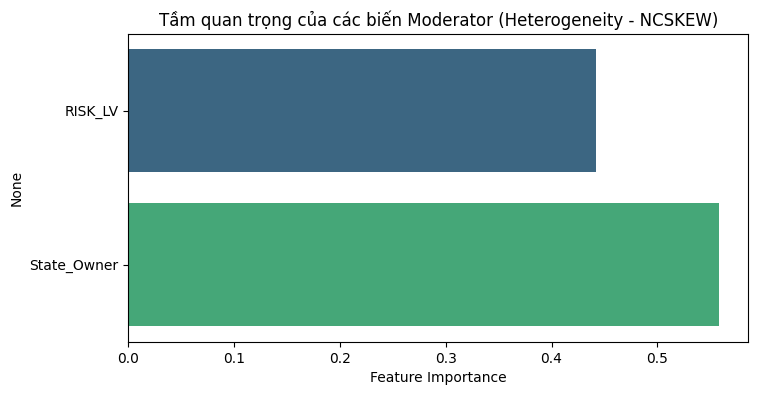


=> TÁC ĐỘNG CỦA NĐ 08 THEO KHẨU VỊ RỦI RO (RISK_LV):
                  RISK_LV      CATE
0            Đòn bẩy thấp -0.076815
1  Đòn bẩy cao (> Median)  0.162763

=> TÁC ĐỘNG CỦA NĐ 08 THEO SỞ HỮU (STATE_OWNER):
  State_Owner      CATE
0     Tư nhân  0.157111
1    Nhà nước -0.469053


In [ ]:
# CELL 3: PHÂN TÍCH TÍNH KHÔNG ĐỒNG NHẤT BẰNG CAUSAL FOREST

print("\n--- PHÂN TÍCH TÍNH KHÔNG ĐỒNG NHẤT BẰNG CAUSAL FOREST DML ---")

def run_causal_forest(Y_col):
    Y = df[Y_col]

    cf_est = CausalForestDML(
        model_y=model_y,
        model_t=model_t,
        discrete_treatment=True,
        cv=cv,
        n_estimators=500,
        random_state=42
    )


    # X (Heterogeneity): Phải là W_original (RISK_LV, State_Owner)
    # W (Controls): Phải là X_original (Các biến tài chính, thị trường)
    cf_est.fit(Y, T, X=W, W=X, groups=groups)

    importance = cf_est.feature_importances_

    cate_df = df[['Ticker', 'RISK_LV', 'State_Owner']].copy()
    # Hàm effect chỉ nhận 1 biến X của Causal Forest (chính là tập W)
    cate_df['CATE'] = cf_est.effect(W)

    return cf_est, importance, cate_df

cf_ncskew, imp_ncskew, cate_ncskew = run_causal_forest('NCSKEW')

# Vẽ biểu đồ
plt.figure(figsize=(8, 4))
# Sửa W.columns thành W (vì dataframe W chứa RISK_LV và State_Owner)
sns.barplot(x=imp_ncskew, y=W.columns, palette='viridis')
plt.title("Tầm quan trọng của các biến Moderator (Heterogeneity - NCSKEW)")
plt.xlabel("Feature Importance")
plt.show()

# In kết quả
print("\n=> TÁC ĐỘNG CỦA NĐ 08 THEO KHẨU VỊ RỦI RO (RISK_LV):")
risk_effect = cate_ncskew.groupby('RISK_LV')['CATE'].mean().reset_index()
risk_effect['RISK_LV'] = risk_effect['RISK_LV'].map({0: 'Đòn bẩy thấp', 1: 'Đòn bẩy cao (> Median)'})
print(risk_effect)

print("\n=> TÁC ĐỘNG CỦA NĐ 08 THEO SỞ HỮU (STATE_OWNER):")
soe_effect = cate_ncskew.groupby('State_Owner')['CATE'].mean().reset_index()
soe_effect['State_Owner'] = soe_effect['State_Owner'].map({0: 'Tư nhân', 1: 'Nhà nước'})
print(soe_effect)

In [ ]:

# CELL 4: ROBUSTNESS TEST - SO SÁNH NHIỀU THUẬT TOÁN & SIÊU THAM SỐ
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from econml.dml import LinearDML, CausalForestDML
from sklearn.model_selection import GroupKFold
import warnings
warnings.filterwarnings('ignore')

print("Đang chạy Robustness Test")

# 1. Định nghĩa từ điển các mô hình và tham số cần so sánh
models_dict = {
    "1. XGBoost_Base": {
        "reg": XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, n_jobs=-1),
        "clf": XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, n_jobs=-1),
        "desc": "Cây nông (Depth=3), tốc độ học chậm"
    },
    "2. XGBoost_Deep": {
        "reg": XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.01, random_state=42, n_jobs=-1),
        "clf": XGBClassifier(n_estimators=150, max_depth=5, learning_rate=0.01, random_state=42, n_jobs=-1),
        "desc": "Cây sâu (Depth=5), tốc độ học rất chậm"
    },
    "3. Random_Forest": {
        "reg": RandomForestRegressor(n_estimators=150, max_depth=5, random_state=42, n_jobs=-1),
        "clf": RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42, n_jobs=-1),
        "desc": "Thuật toán Bagging truyền thống"
    },
    "4. LightGBM": {
        "reg": LGBMRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, n_jobs=-1, verbose=-1),
        "clf": LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, n_jobs=-1, verbose=-1),
        "desc": "Tối ưu hóa tốc độ và chống Overfitting tốt"
    }
}

cv_robust = GroupKFold(n_splits=5)
results_list = []

# Vòng lặp chạy qua từng mô hình
for model_name, config in models_dict.items():
    print(f"-> Đang huấn luyện: {model_name}...")
    try:
        model_y = config["reg"]
        model_t = config["clf"]

        row_result = {
            "Model": model_name,
            "Hyperparameters": config["desc"]
        }

        # --- TEST 1: TÁC ĐỘNG TRUNG BÌNH (ATE) LÊN NCSKEW ---
        dml_ncskew = LinearDML(model_y=model_y, model_t=model_t, discrete_treatment=True, cv=cv_robust, random_state=42)
        dml_ncskew.fit(df['NCSKEW'], T, X=None, W=X_all, groups=groups, cache_values=True)

        # Lấy ATE và P-value
        ate_summary = dml_ncskew.summary().tables[0] # Lấy bảng CATE Intercept
        row_result["ATE_NCSKEW"] = float(ate_summary.data[1][1]) # point_estimate
        row_result["P_val_NCSKEW"] = float(ate_summary.data[1][4]) # pvalue

        # --- TEST 2: CAUSAL FOREST TÍNH KHÔNG ĐỒNG NHẤT (SOE) LÊN NCSKEW ---
        cf_ncskew = CausalForestDML(model_y=model_y, model_t=model_t, discrete_treatment=True,
                                    cv=cv_robust, n_estimators=400, random_state=42)
        cf_ncskew.fit(df['NCSKEW'], T, X=W, W=X, groups=groups)

        cate_values = cf_ncskew.effect(W)
        df_temp = W.copy()
        df_temp['CATE'] = cate_values

        # Lấy CATE cho Tư nhân (0) và Nhà nước (1)
        row_result["CATE_Private"] = df_temp[df_temp['State_Owner'] == 0]['CATE'].mean()
        row_result["CATE_SOE"] = df_temp[df_temp['State_Owner'] == 1]['CATE'].mean()

        results_list.append(row_result)

    except Exception as e:
        print(f"Lỗi ở mô hình {model_name}: {e}")

# Tổng hợp thành DataFrame
df_robustness = pd.DataFrame(results_list)

# Làm tròn số cho đẹp
df_robustness['ATE_NCSKEW'] = df_robustness['ATE_NCSKEW'].round(4)
df_robustness['P_val_NCSKEW'] = df_robustness['P_val_NCSKEW'].round(3)
df_robustness['CATE_Private'] = df_robustness['CATE_Private'].round(4)
df_robustness['CATE_SOE'] = df_robustness['CATE_SOE'].round(4)

print("\n HOÀN THÀNH ROBUSTNESS TEST! KẾT QUẢ TỔNG HỢP:")
import IPython.display as display
display.display(df_robustness)

# Xuất ra Excel để dán vào bài viết
df_robustness.to_excel('Robustness_Check_Results.xlsx', index=False)
print("Đã lưu bảng kết quả vào file 'Robustness_Check_Results.xlsx'")

Đang chạy Robustness Test... Quá trình này có thể mất 2-5 phút tùy cấu hình máy...
-> Đang huấn luyện: 1. XGBoost_Base...
Coefficient Results:  X is None, please call intercept_inference to learn the constant!
-> Đang huấn luyện: 2. XGBoost_Deep...
Coefficient Results:  X is None, please call intercept_inference to learn the constant!
-> Đang huấn luyện: 3. Random_Forest...
Coefficient Results:  X is None, please call intercept_inference to learn the constant!
-> Đang huấn luyện: 4. LightGBM...
Coefficient Results:  X is None, please call intercept_inference to learn the constant!

 HOÀN THÀNH ROBUSTNESS TEST! KẾT QUẢ TỔNG HỢP:


,Model,Hyperparameters,ATE_NCSKEW,P_val_NCSKEW,CATE_Private,CATE_SOE
0,1. XGBoost_Base,"Cây nông (Depth=3), tốc độ học chậm",0.094,0.306,0.1278,-0.3784
1,2. XGBoost_Deep,"Cây sâu (Depth=5), tốc độ học rất chậm",0.048,0.626,0.0969,-0.5284
2,3. Random_Forest,Thuật toán Bagging truyền thống,0.146,0.126,0.1855,-0.3188
3,4. LightGBM,Tối ưu hóa tốc độ và chống Overfitting tốt,0.093,0.315,0.1071,-0.2893


Đã lưu bảng kết quả vào file 'Robustness_Check_Results.xlsx'
